# Preprocesamiento de Biomarcadores - Proyecto Monitorización Multimodal de Alzheimer


Este cuaderno se enfoca en el preprocesamiento de los datos de biomarcadores identificados durante la fase de EDA. Nos basaremos en los hallazgos del análisis exploratorio previo donde identificamos:

- Biomarcadores clave: TAU, PTAU, Glucosa
- Datos con valores faltantes, especialmente en BIOMARK
- Necesidad de estandarización de nombres y unidades

---

## Importación de bibliotecas

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer


In [37]:
# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

# Configuración para mostrar más columnas
pd.set_option('display.max_columns', None)

## Carga de datos

In [38]:
# Definir la ruta de los datos
data_path = "../data/raw/adni/biomarkers"

# Cargar los archivos de biomarcadores
biomark_df = pd.read_csv(os.path.join(data_path, "BIOMARK.csv"), low_memory=False)
lcrlab_df = pd.read_csv(os.path.join(data_path, "LCRLAB.csv"), low_memory=False)
roche_df = pd.read_csv(os.path.join(data_path, "UPENNBIOMK_ROCHE_ELECSYS.csv"), low_memory=False)
urmc_df = pd.read_csv(os.path.join(data_path, "URMC_LABDATA.csv"), low_memory=False)

In [39]:
# Información básica sobre los datasets
print("Tamaño de BIOMARK:", biomark_df.shape)
print("Tamaño de LCRLAB:", lcrlab_df.shape)
print("Tamaño de ROCHE ELECSYS:", roche_df.shape)
print("Tamaño de URMC LABDATA:", urmc_df.shape)

Tamaño de BIOMARK: (13416, 65)
Tamaño de LCRLAB: (8072, 22)
Tamaño de ROCHE ELECSYS: (3174, 13)
Tamaño de URMC LABDATA: (113402, 28)


## Inspección inicial de los datos

In [40]:
# Revisamos las primeras filas de cada dataset
print("BIOMARK primeras filas:")
display(biomark_df.head())

print("\nLCRLAB primeras filas:")
display(lcrlab_df.head())

print("\nROCHE ELECSYS primeras filas:")
display(roche_df.head())

print("\nURMC LABDATA primeras filas:")
display(urmc_df.head())

## Identificación de variables comunes y estandarización

# Examinamos las columnas de cada dataset
print("- Columnas en BIOMARK:", biomark_df.columns.tolist())
print("\n- Columnas en LCRLAB:", lcrlab_df.columns.tolist())
print("\n- Columnas en ROCHE_ELECSYS:", roche_df.columns.tolist())
print("\n- Columnas en URMC_LABDATA:", urmc_df.columns.tolist())

# Identificar columnas comunes que podrían servir como clave para unir datasets
common_columns = set(biomark_df.columns) & set(lcrlab_df.columns) & set(roche_df.columns) & set(urmc_df.columns)
print("\n+ Columnas comunes en todos los datasets:", common_columns)

BIOMARK primeras filas:


,PHASE,PTID,RID,VISCODE,VISCODE2,EXAMDATE,RECNO,BIBLOOD,BIURINE,BLREASON,BIFAST,BITIME,BIREDTIME,BIREDAMT,BIREDCENT,BIREDTRNS,BIREDVOL,BIREDFROZ,BILAVTIME,BINEEDLE,BILAVAMT,BILAVCENT,BILAVTRNS,BILAVVOL,BILAVFROZ,BIURITIME,BIURIAMT,BIURITRNS,BIURIVOL,BIURIFROZ,BICSF,BINONE,REASON,BICSFFAST,BICSFTIME,BIMETHOD,NEEDLESIZE,INTERSPACE,PTPOSITION,COLTUBETYP,SHPTUBETYP,TUBEMIN,BICSFAMT,BICSFTRNS,BICSFVOL,BICSFFROZ,BILPPATCH,BILPFLURO,BILPSPFILM,BILPPADATE,BILPFLDATE,BILPSPDATE,BILPPADATEYR_DRVD,BILPFLDATEYR_DRVD,BILPSPDATEYR_DRVD,BILPOTPROC,BIFEDDATE,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0002,2,bl,bl,2005-09-08,1.0,1.0,1.0,NaN,0.0,1003,1003,20.0,1033,1104,4.0,1105,1003,-4.0,20.0,1033,1103,7.0,1104,1005,50.0,1105,9.0,1106,-4.0,-4.0,NaN,NaN,-4,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4,-4.0,-4,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,4,107,2005-09-09,NaN,NaN,NaN,NaN,2005-09-09 00:00:00.0
1,ADNI1,011_S_0005,5,bl,bl,2005-09-07,1.0,1.0,1.0,NaN,0.0,1203,930,10.0,1000,1015,5.0,1016,930,1.0,10.0,1000,1015,5.0,1016,1130,30.0,1250,13.0,1300,1.0,-4.0,NaN,NaN,1203,2.0,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1220,15.0,1225,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,6,107,2005-09-09,NaN,NaN,NaN,NaN,2005-09-09 00:00:00.0
2,ADNI1,011_S_0003,3,bl,bl,2005-09-12,1.0,1.0,1.0,NaN,0.0,945,943,20.0,1015,1031,9.0,1032,945,1.0,20.0,1015,1034,8.0,1035,956,35.0,1029,10.0,1030,1.0,-4.0,NaN,NaN,1125,2.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1126,15.0,1130,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,8,107,2005-09-13,NaN,NaN,NaN,NaN,2005-09-13 00:00:00.0
3,ADNI1,011_S_0008,8,bl,bl,2005-09-19,1.0,1.0,1.0,NaN,0.0,1250,1250,20.0,1320,1337,11.0,1338,1250,1.0,20.0,1320,1337,7.0,1339,1130,90.0,1234,10.0,1235,1.0,-4.0,NaN,NaN,1155,2.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1200,15.0,1203,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,10,107,2005-09-27,NaN,NaN,NaN,NaN,2005-09-27 00:00:00.0
4,ADNI1,022_S_0007,7,bl,bl,2005-10-06,1.0,1.0,1.0,NaN,1.0,1036,1036,8.0,1123,1145,5.0,1200,1036,-4.0,8.0,1123,1150,5.0,1205,1040,35.0,1050,13.0,1055,-4.0,-4.0,NaN,NaN,-4,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4,-4.0,-4,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,12,10,2005-10-06,NaN,NaN,NaN,NaN,2005-10-06 00:00:00.0



LCRLAB primeras filas:


,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,SAMPLECOLL,LABLOOD,CTWHITE,CTRED,PROTEIN,GLUCOSE,SAMPLETIME,SENTTIME,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,023_S_0031,31,bl,bl,2005-10-24,NaN,NaN,1.0,160.0,37.0,63.0,10:00:00,1100,2,11,2005-10-25,NaN,NaN,NaN,NaN,2005-10-25 00:00:00.0
1,ADNI1,023_S_0042,42,bl,bl,2005-11-10,NaN,NaN,2.0,0.0,55.0,100.0,08:35:00,940,4,11,2005-11-11,NaN,NaN,NaN,NaN,2005-11-11 00:00:00.0
2,ADNI1,007_S_0041,41,bl,bl,2005-11-14,NaN,NaN,2.0,0.0,39.0,57.0,09:30:00,930,6,2,2005-11-14,NaN,NaN,NaN,NaN,2005-11-14 00:00:00.0
3,ADNI1,011_S_0023,23,bl,bl,2005-11-08,NaN,NaN,2.0,110.0,30.0,54.0,09:18:00,1215,8,107,2005-11-14,NaN,NaN,NaN,NaN,2005-11-14 00:00:00.0
4,ADNI1,011_S_0010,10,bl,bl,2005-11-15,NaN,NaN,0.0,66.0,35.0,52.0,09:17:00,1205,10,107,2005-12-09,NaN,NaN,NaN,NaN,2005-12-09 00:00:00.0



ROCHE ELECSYS primeras filas:


,PHASE,PTID,RID,VISCODE2,EXAMDATE,BATCH,RUNDATE,ABETA40,ABETA42,TAU,PTAU,COMMENT,update_stamp
0,ADNI1,011_S_0003,3,bl,2005-09-12,UPENNBIOMK9,2016-12-14,NaN,741.5,239.7,22.83,NaN,2024-01-12 11:11:42.0
1,ADNI1,011_S_0003,3,m12,2006-09-13,UPENNBIOMK9,2016-12-14,NaN,601.4,251.7,24.18,NaN,2024-01-12 11:11:42.0
2,ADNI1,022_S_0004,4,bl,2005-11-22,UPENNBIOMK9,2017-01-09,NaN,1501.0,153.1,13.29,NaN,2024-01-12 11:11:42.0
3,ADNI1,022_S_0004,4,m12,2006-11-28,UPENNBIOMK9,2017-01-09,NaN,1176.0,159.7,13.30,NaN,2024-01-12 11:11:42.0
4,ADNI1,011_S_0005,5,bl,2005-09-07,UPENNBIOMK9,2016-11-22,NaN,547.3,337.0,33.43,NaN,2024-01-12 11:11:42.0



URMC LABDATA primeras filas:


,PHASE,PTID,RID,VISCODE,VISCODE2,SampleDate,SampleTime,RecDate,RecTime,KitID,TestID,TestName,ResultValue,Flags,Comments,LowerRange,UpperRange,Units,ResultValueConv,LowerRangeConv,UpperRangeConv,UnitsConv,ResultValueSI,LowerRangeSI,UpperRangeSI,UnitsSI,Fasting,update_stamp
0,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,CK,Creatine Kinase,73,NaN,NaN,34,145,U/L,73,34,145,U/L,73,34,145,U/L,NaN,2022-01-10 03:14:38.0
1,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,NaN,Sodium,138,NaN,NaN,133,145,mmol/L,138,133,145,mmol/L,138,133,145,mmol/L,NaN,2022-01-10 03:14:38.0
2,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,K,Potassium,3.9,NaN,NaN,3.3,5.1,mmol/L,3.9,3.3,5.1,mmol/L,3.9,3.3,5.1,mmol/L,NaN,2022-01-10 03:14:38.0
3,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,CL,Chloride,99,NaN,NaN,96,108,mmol/L,99,96,108,mmol/L,99,96,108,mmol/L,NaN,2022-01-10 03:14:38.0
4,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,CO2,CO2,25,NaN,NaN,20,28,mmol/L,25,20,28,mmol/L,25,20,28,mmol/L,NaN,2022-01-10 03:14:38.0


- Columnas en BIOMARK: ['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'EXAMDATE', 'RECNO', 'BIBLOOD', 'BIURINE', 'BLREASON', 'BIFAST', 'BITIME', 'BIREDTIME', 'BIREDAMT', 'BIREDCENT', 'BIREDTRNS', 'BIREDVOL', 'BIREDFROZ', 'BILAVTIME', 'BINEEDLE', 'BILAVAMT', 'BILAVCENT', 'BILAVTRNS', 'BILAVVOL', 'BILAVFROZ', 'BIURITIME', 'BIURIAMT', 'BIURITRNS', 'BIURIVOL', 'BIURIFROZ', 'BICSF', 'BINONE', 'REASON', 'BICSFFAST', 'BICSFTIME', 'BIMETHOD', 'NEEDLESIZE', 'INTERSPACE', 'PTPOSITION', 'COLTUBETYP', 'SHPTUBETYP', 'TUBEMIN', 'BICSFAMT', 'BICSFTRNS', 'BICSFVOL', 'BICSFFROZ', 'BILPPATCH', 'BILPFLURO', 'BILPSPFILM', 'BILPPADATE', 'BILPFLDATE', 'BILPSPDATE', 'BILPPADATEYR_DRVD', 'BILPFLDATEYR_DRVD', 'BILPSPDATEYR_DRVD', 'BILPOTPROC', 'BIFEDDATE', 'ID', 'SITEID', 'USERDATE', 'USERDATE2', 'DD_CRF_VERSION_LABEL', 'LANGUAGE_CODE', 'HAS_QC_ERROR', 'update_stamp']

- Columnas en LCRLAB: ['PHASE', 'PTID', 'RID', 'VISCODE', 'VISCODE2', 'VISDATE', 'SAMPLECOLL', 'LABLOOD', 'CTWHITE', 'CTRED', 'PROTEIN', 'GLUC

## Preprocesamiento de BIOMARK.csv

In [41]:
def preprocess_biomark(df):
    """
    Función para preprocesar el dataset BIOMARK
    """
    # Crear una copia para no modificar el original
    processed_df = df.copy()
    
    # Convertir columnas a tipos apropiados
    # Asumimos que RID es el identificador único del paciente
    processed_df['RID'] = processed_df['RID'].astype(str)
    
    # Identificar y convertir columnas con tipos mixtos a formatos adecuados
    # Primero, identificar columnas que probablemente deberían ser numéricas
    potential_numeric_cols = []
    for col in processed_df.columns:
        if col in ['ABETA', 'TAU', 'PTAU'] or col.startswith('RESULT'):
            potential_numeric_cols.append(col)
    
    # Convertir columnas con tipos mixtos a numérico, si es posible
    for col in potential_numeric_cols:
        if col in processed_df.columns:
            # Intentar convertir a numérico, colocando NaN donde no sea posible
            processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
    
    # Identificar las columnas numéricas (biomarcadores)
    numeric_cols = processed_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Verificar valores faltantes
    missing_values = processed_df[numeric_cols].isnull().sum()
    print("Valores faltantes por columna:")
    print(missing_values)

    
    return processed_df

# Aplicar el preprocesamiento
biomark_processed = preprocess_biomark(biomark_df)
print("BIOMARK después del preprocesamiento:")
display(biomark_processed.head())

Valores faltantes por columna:
RECNO                 3633
BIBLOOD                132
BIURINE               9190
BLREASON              7984
BIFAST                 908
BIREDAMT               974
BIREDVOL               992
BINEEDLE              9015
BILAVAMT               983
BILAVVOL              1004
BIURIAMT              9190
BIURIVOL              9190
BICSF                 1148
BINONE                9185
REASON                7873
BICSFFAST            11101
BIMETHOD              6709
NEEDLESIZE           11117
INTERSPACE           11162
PTPOSITION           11108
COLTUBETYP           11146
SHPTUBETYP           11156
TUBEMIN              13390
BICSFAMT              6710
BICSFVOL              6882
BILPPATCH             9178
BILPFLURO             8947
BILPSPFILM            9188
BILPPADATEYR_DRVD    13387
BILPFLDATEYR_DRVD    12848
BILPSPDATEYR_DRVD    13408
ID                       0
SITEID                   0
HAS_QC_ERROR         12629
dtype: int64
BIOMARK después del preprocesamiento:


,PHASE,PTID,RID,VISCODE,VISCODE2,EXAMDATE,RECNO,BIBLOOD,BIURINE,BLREASON,BIFAST,BITIME,BIREDTIME,BIREDAMT,BIREDCENT,BIREDTRNS,BIREDVOL,BIREDFROZ,BILAVTIME,BINEEDLE,BILAVAMT,BILAVCENT,BILAVTRNS,BILAVVOL,BILAVFROZ,BIURITIME,BIURIAMT,BIURITRNS,BIURIVOL,BIURIFROZ,BICSF,BINONE,REASON,BICSFFAST,BICSFTIME,BIMETHOD,NEEDLESIZE,INTERSPACE,PTPOSITION,COLTUBETYP,SHPTUBETYP,TUBEMIN,BICSFAMT,BICSFTRNS,BICSFVOL,BICSFFROZ,BILPPATCH,BILPFLURO,BILPSPFILM,BILPPADATE,BILPFLDATE,BILPSPDATE,BILPPADATEYR_DRVD,BILPFLDATEYR_DRVD,BILPSPDATEYR_DRVD,BILPOTPROC,BIFEDDATE,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,011_S_0002,2,bl,bl,2005-09-08,1.0,1.0,1.0,NaN,0.0,1003,1003,20.0,1033,1104,4.0,1105,1003,-4.0,20.0,1033,1103,7.0,1104,1005,50.0,1105,9.0,1106,-4.0,-4.0,NaN,NaN,-4,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4,-4.0,-4,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,4,107,2005-09-09,NaN,NaN,NaN,NaN,2005-09-09 00:00:00.0
1,ADNI1,011_S_0005,5,bl,bl,2005-09-07,1.0,1.0,1.0,NaN,0.0,1203,930,10.0,1000,1015,5.0,1016,930,1.0,10.0,1000,1015,5.0,1016,1130,30.0,1250,13.0,1300,1.0,-4.0,NaN,NaN,1203,2.0,NaN,NaN,NaN,NaN,NaN,NaN,17.0,1220,15.0,1225,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,6,107,2005-09-09,NaN,NaN,NaN,NaN,2005-09-09 00:00:00.0
2,ADNI1,011_S_0003,3,bl,bl,2005-09-12,1.0,1.0,1.0,NaN,0.0,945,943,20.0,1015,1031,9.0,1032,945,1.0,20.0,1015,1034,8.0,1035,956,35.0,1029,10.0,1030,1.0,-4.0,NaN,NaN,1125,2.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1126,15.0,1130,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,8,107,2005-09-13,NaN,NaN,NaN,NaN,2005-09-13 00:00:00.0
3,ADNI1,011_S_0008,8,bl,bl,2005-09-19,1.0,1.0,1.0,NaN,0.0,1250,1250,20.0,1320,1337,11.0,1338,1250,1.0,20.0,1320,1337,7.0,1339,1130,90.0,1234,10.0,1235,1.0,-4.0,NaN,NaN,1155,2.0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,1200,15.0,1203,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,10,107,2005-09-27,NaN,NaN,NaN,NaN,2005-09-27 00:00:00.0
4,ADNI1,022_S_0007,7,bl,bl,2005-10-06,1.0,1.0,1.0,NaN,1.0,1036,1036,8.0,1123,1145,5.0,1200,1036,-4.0,8.0,1123,1150,5.0,1205,1040,35.0,1050,13.0,1055,-4.0,-4.0,NaN,NaN,-4,-4.0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0,-4,-4.0,-4,-4.0,-4.0,-4.0,-4,-4,-4,NaN,NaN,NaN,NaN,NaN,12,10,2005-10-06,NaN,NaN,NaN,NaN,2005-10-06 00:00:00.0


Luego del EDA y del preprocesamiento inicial podemos concluir que este archivo de biomarcadores 'BIOMARK.csv' no tiene columnas relevantes para nuestro análisis.

## Preprocesamiento de LCRLAB.csv

In [42]:
def preprocess_lcrlab(df):
    """
    Preprocesa el dataset LCRLAB:
    - Copia el DataFrame original
    - Convierte RID a string
    - Imputa medianas biomarcadores (solo GLUCOSE en este caso)
    """
    processed_df = df.copy()
    processed_df['RID'] = processed_df['RID'].astype(str)

    # Solo interesa GLUCOSE
    biomarker_cols = ['GLUCOSE']

    for col in biomarker_cols:
        missing_before = processed_df[col].isnull().sum()
        if missing_before > 0:
            median_value = processed_df[col].median()
            # Imputación efectiva
            processed_df[col] = processed_df[col].fillna(median_value)
            print(f"Imputados {missing_before} valores faltantes en '{col}' con la mediana: {median_value}")

    return processed_df

# Uso:
lcrlab_processed = preprocess_lcrlab(lcrlab_df)
print("LCRLAB después del preprocesamiento:")
display(lcrlab_processed.head())


Imputados 4904 valores faltantes en 'GLUCOSE' con la mediana: 58.0
LCRLAB después del preprocesamiento:


,PHASE,PTID,RID,VISCODE,VISCODE2,VISDATE,SAMPLECOLL,LABLOOD,CTWHITE,CTRED,PROTEIN,GLUCOSE,SAMPLETIME,SENTTIME,ID,SITEID,USERDATE,USERDATE2,DD_CRF_VERSION_LABEL,LANGUAGE_CODE,HAS_QC_ERROR,update_stamp
0,ADNI1,023_S_0031,31,bl,bl,2005-10-24,NaN,NaN,1.0,160.0,37.0,63.0,10:00:00,1100,2,11,2005-10-25,NaN,NaN,NaN,NaN,2005-10-25 00:00:00.0
1,ADNI1,023_S_0042,42,bl,bl,2005-11-10,NaN,NaN,2.0,0.0,55.0,100.0,08:35:00,940,4,11,2005-11-11,NaN,NaN,NaN,NaN,2005-11-11 00:00:00.0
2,ADNI1,007_S_0041,41,bl,bl,2005-11-14,NaN,NaN,2.0,0.0,39.0,57.0,09:30:00,930,6,2,2005-11-14,NaN,NaN,NaN,NaN,2005-11-14 00:00:00.0
3,ADNI1,011_S_0023,23,bl,bl,2005-11-08,NaN,NaN,2.0,110.0,30.0,54.0,09:18:00,1215,8,107,2005-11-14,NaN,NaN,NaN,NaN,2005-11-14 00:00:00.0
4,ADNI1,011_S_0010,10,bl,bl,2005-11-15,NaN,NaN,0.0,66.0,35.0,52.0,09:17:00,1205,10,107,2005-12-09,NaN,NaN,NaN,NaN,2005-12-09 00:00:00.0


## Preprocesamiento de UPENNBIOMK_ROCHE_ELECSYS.csv

In [43]:
def preprocess_roche(df):
    """
    Función para preprocesar el dataset UPENNBIOMK_ROCHE_ELECSYS
    """
    # Crear una copia para no modificar el original
    processed_df = df.copy()
    
    # Convertir columnas a tipos apropiados
    processed_df['RID'] = processed_df['RID'].astype(str)
    
    # Identificar y manejar valores faltantes
    missing_values = processed_df.isnull().sum()
    print("Valores faltantes por columna:")
    print(missing_values)
    
    # Manejo específico de valores faltantes para ABETA40, ABETA42, TAU, PTAU
    key_biomarkers = ['ABETA40', 'ABETA42', 'TAU', 'PTAU']
    for biomarker in key_biomarkers:
        if biomarker in processed_df.columns:
            # Verificar número de valores faltantes
            n_missing = processed_df[biomarker].isnull().sum()
            
            if n_missing > 0:
                print(f"Imputando {n_missing} valores faltantes en {biomarker}")
                
                # Si hay más del 50% de valores faltantes, usar la mediana para imputar
                if n_missing / len(processed_df) > 0.5:
                    median_value = processed_df[biomarker].median()
                    #processed_df[biomarker].fillna(median_value, inplace=True)
                    processed_df[biomarker] = processed_df[biomarker].fillna(median_value)
                    
                    print(f"  - Usando imputación por mediana: {median_value}")
                else:
                    # Si hay menos del 50%, usar KNN para una imputación más precisa
                    try:
                        # Seleccionar otras columnas numéricas para la imputación
                        numeric_cols = processed_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
                        # Excluir biomarkers con muchos valores faltantes
                        imputation_cols = [col for col in numeric_cols if processed_df[col].isnull().sum() / len(processed_df) < 0.3]
                        
                        if biomarker in imputation_cols:
                            imputation_cols.remove(biomarker)
                        
                        if len(imputation_cols) >= 2:  # Necesitamos al menos un par de columnas para KNN
                            # Crear un dataset temporal para la imputación
                            impute_df = processed_df[[biomarker] + imputation_cols].copy()
                            
                            # Aplicar KNN imputer
                            imputer = KNNImputer(n_neighbors=5)
                            imputed_values = imputer.fit_transform(impute_df)
                            
                            # Actualizar solo la columna objetivo
                            processed_df[biomarker] = imputed_values[:, 0]
                            print(f"  - Usando imputación KNN con {len(imputation_cols)} variables predictoras")
                        else:
                            # Si no hay suficientes predictores, usar la mediana
                            median_value = processed_df[biomarker].median()
                            #processed_df[biomarker].fillna(median_value, inplace=True)
                            processed_df[biomarker] = processed_df[biomarker].fillna(median_value)
                            print(f"  - Usando imputación por mediana (no hay suficientes predictores para KNN): {median_value}")
                    except Exception as e:
                        # En caso de error, usar la mediana como fallback
                        print(f"  - Error en imputación KNN: {str(e)}")
                        median_value = processed_df[biomarker].median()
                        #processed_df[biomarker].fillna(median_value, inplace=True)
                        processed_df[biomarker] = processed_df[biomarker].fillna(median_value)
                        print(f"  - Fallback a imputación por mediana: {median_value}")
    
    # Normalización de biomarcadores
    # Primero identificamos las columnas numéricas que son biomarcadores
    biomarker_cols = processed_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    biomarker_cols = [col for col in biomarker_cols if col not in ['RID']]  # Excluir identificadores
    
    # Verificar si hay datos suficientes para la normalización
    if len(biomarker_cols) > 0 and processed_df[biomarker_cols].dropna().shape[0] > 0:
        # Normalización z-score
        scaler = StandardScaler()
        try:
            processed_df[biomarker_cols] = scaler.fit_transform(processed_df[biomarker_cols])
            
            # Agregamos columnas con información de si el biomarcador está dentro de rangos normales
            for col in biomarker_cols:
                processed_df[f'{col}_NORMAL'] = ((processed_df[col] >= -2) & (processed_df[col] <= 2)).astype(int)
        except Exception as e:
            print(f"Error en normalización: {str(e)}")
            print("Intentando normalizar columna por columna...")
            
            # Intentar normalizar columna por columna como alternativa
            for col in biomarker_cols:
                if processed_df[col].isnull().sum() < len(processed_df):  # Si hay algunos valores no nulos
                    try:
                        values = processed_df[[col]].values.reshape(-1, 1)
                        scaler = StandardScaler()
                        processed_df[col] = scaler.fit_transform(values)
                        processed_df[f'{col}_NORMAL'] = ((processed_df[col] >= -2) & (processed_df[col] <= 2)).astype(int)
                    except:
                        print(f"No se pudo normalizar la columna {col}")
    else:
        print("No hay suficientes datos no nulos para realizar normalización")

    # Calcular ratios importantes que podrían ser útiles para el análisis
    # Ejemplo: Ratio TAU/ABETA es un biomarcador importante para Alzheimer
    if 'ABETA42' in processed_df.columns and 'PTAU' in processed_df.columns:
        # Evitar división por cero
        processed_df['ABETA42_PTAU_RATIO'] = processed_df['ABETA42'] / processed_df['PTAU'].replace(0, np.nan)
        
    if 'ABETA42' in processed_df.columns and 'ABETA40' in processed_df.columns:
        processed_df['ABETA42_ABETA40_RATIO'] = processed_df['ABETA42'] / processed_df['ABETA40'].replace(0, np.nan)

    if 'PTAU' in processed_df.columns and 'TAU' in processed_df.columns:
        processed_df['PTAU_TAU_RATIO'] = processed_df['PTAU'] / processed_df['TAU'].replace(0, np.nan)
    
    return processed_df
    

# Aplicar el preprocesamiento
roche_processed = preprocess_roche(roche_df)
print("ROCHE ELECSYS después del preprocesamiento:")
display(roche_processed.head())

Valores faltantes por columna:
PHASE              0
PTID               0
RID                0
VISCODE2           0
EXAMDATE           0
BATCH              0
RUNDATE            0
ABETA40         2240
ABETA42            7
TAU               15
PTAU              27
COMMENT         2746
update_stamp       0
dtype: int64
Imputando 2240 valores faltantes en ABETA40
  - Usando imputación por mediana: 17700.0
Imputando 7 valores faltantes en ABETA42
  - Usando imputación KNN con 3 variables predictoras
Imputando 15 valores faltantes en TAU
  - Usando imputación KNN con 3 variables predictoras
Imputando 27 valores faltantes en PTAU
  - Usando imputación KNN con 3 variables predictoras
ROCHE ELECSYS después del preprocesamiento:


,PHASE,PTID,RID,VISCODE2,EXAMDATE,BATCH,RUNDATE,ABETA40,ABETA42,TAU,PTAU,COMMENT,update_stamp,ABETA40_NORMAL,ABETA42_NORMAL,TAU_NORMAL,PTAU_NORMAL,ABETA42_PTAU_RATIO,ABETA42_ABETA40_RATIO,PTAU_TAU_RATIO
0,ADNI1,011_S_0003,3,bl,2005-09-12,UPENNBIOMK9,2016-12-14,-0.040688,-0.516520,-0.365326,-0.307606,NaN,2024-01-12 11:11:42.0,1,1,1,1,1.679161,12.694796,0.842003
1,ADNI1,011_S_0003,3,m12,2006-09-13,UPENNBIOMK9,2016-12-14,-0.040688,-0.742509,-0.271758,-0.212966,NaN,2024-01-12 11:11:42.0,1,1,1,1,3.486517,18.249052,0.783661
2,ADNI1,022_S_0004,4,bl,2005-11-22,UPENNBIOMK9,2017-01-09,-0.040688,0.708595,-1.040580,-0.976396,NaN,2024-01-12 11:11:42.0,1,1,1,1,-0.725725,-17.415535,0.938319
3,ADNI1,022_S_0004,4,m12,2006-11-28,UPENNBIOMK9,2017-01-09,-0.040688,0.184352,-0.989117,-0.975695,NaN,2024-01-12 11:11:42.0,1,1,1,1,-0.188945,-4.530930,0.986430
4,ADNI1,011_S_0005,5,bl,2005-09-07,UPENNBIOMK9,2016-11-22,-0.040688,-0.829775,0.393360,0.435494,NaN,2024-01-12 11:11:42.0,1,1,1,1,-1.905363,20.393843,1.107115


## Preprocesamiento de URMC_LABDATA.csv

In [44]:
def preprocess_urmc(df):
    """
    Función para preprocesar el dataset URMC_LABDATA
    """
    # Crear una copia para no modificar el original
    processed_df = df.copy()
    
    # Convertir columnas a tipos apropiados
    processed_df['RID'] = processed_df['RID'].astype(str)
    
    # Manejar columnas con tipos mixtos identificadas en la advertencia (columnas 19,23,24,26)
    mixed_cols = []
    # Determinar cuáles son esas columnas basándose en su posición
    if len(processed_df.columns) > 26:  # Asegurar que hay suficientes columnas
        mixed_cols = [processed_df.columns[18], processed_df.columns[22], 
                      processed_df.columns[23], processed_df.columns[25]]
        print(f"Columnas con tipos mixtos: {mixed_cols}")
        
        # Convertir a tipos adecuados
        for col in mixed_cols:
            # Para columnas que deberían ser numéricas
            if any(substring in col.upper() for substring in ['GLUC', 'VALUE', 'RESULT', 'LAB']):
                processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
            # Para columnas que deberían ser categóricas/texto
            else:
                processed_df[col] = processed_df[col].astype(str)
    
    # Estandarización de unidades (mencionado en el EDA)
    if 'UnitsSI' in processed_df.columns:
        # Asegurarse de que la columna sea de tipo string para evitar problemas de comparación
        processed_df['UnitsSI'] = processed_df['UnitsSI'].astype(str)
        
        # Verificar los tipos únicos de unidades
        print("Unidades únicas en UnitsSI:")
        print(processed_df['UnitsSI'].unique())
        
        # Estandarizar unidades según sea necesario
        # Ejemplo: convertir todas las unidades de glucosa a mg/dL
        if 'GLUC' in processed_df.columns:
            # Asegurarse de que GLUC sea numérico
            processed_df['GLUC'] = pd.to_numeric(processed_df['GLUC'], errors='coerce')
            
            # Convertir de mmol/L a mg/dL
            mask_mmol = processed_df['UnitsSI'] == 'mmol/L'
            processed_df.loc[mask_mmol, 'GLUC'] = processed_df.loc[mask_mmol, 'GLUC'] * 18
            processed_df.loc[mask_mmol, 'UnitsSI'] = 'mg/dL'
    
    # Manejar valores extremos en biomarcadores específicos
    # Ejemplo para glucosa
    if 'GLUC' in processed_df.columns:
        # Asegurarse de que GLUC sea numérico antes de operar
        processed_df['GLUC'] = pd.to_numeric(processed_df['GLUC'], errors='coerce')
        
        # Visualizar antes de la limpieza si hay datos suficientes
        if processed_df['GLUC'].dropna().shape[0] > 0:
            plt.figure(figsize=(10, 6))
            sns.histplot(processed_df['GLUC'].dropna(), kde=True)
            plt.title('Distribución de Glucosa antes de limpieza')
            plt.show()
            
            # Eliminar valores físicamente imposibles
            processed_df = processed_df[
                (processed_df['GLUC'].isna()) | 
                ((processed_df['GLUC'] > 0) & (processed_df['GLUC'] < 1000))
            ]
            
            # Visualizar después de la limpieza
            plt.figure(figsize=(10, 6))
            sns.histplot(processed_df['GLUC'].dropna(), kde=True)
            plt.title('Distribución de Glucosa después de limpieza')
            plt.show()
        else:
            print("No hay datos suficientes en la columna GLUC para visualizar")
    
    return processed_df

# Aplicar el preprocesamiento
urmc_processed = preprocess_urmc(urmc_df)
print("URMC LABDATA después del preprocesamiento:")
display(urmc_processed.head())

Columnas con tipos mixtos: ['ResultValueConv', 'ResultValueSI', 'LowerRangeSI', 'UnitsSI']
Unidades únicas en UnitsSI:
['U/L' 'mmol/L' 'umol/L' 'g/L' 'pmol/L' '10^12/L' '%' '10^9/L' 'nan'
 'Ery/uL' '/hpf' '/lpf' 'sec' '10^3/uL' 'mIU/L' 'Leu/uL' 'mg/L' 'nmol/L'
 'fmol' 'fL' 'mg/dL']
URMC LABDATA después del preprocesamiento:


,PHASE,PTID,RID,VISCODE,VISCODE2,SampleDate,SampleTime,RecDate,RecTime,KitID,TestID,TestName,ResultValue,Flags,Comments,LowerRange,UpperRange,Units,ResultValueConv,LowerRangeConv,UpperRangeConv,UnitsConv,ResultValueSI,LowerRangeSI,UpperRangeSI,UnitsSI,Fasting,update_stamp
0,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,CK,Creatine Kinase,73,NaN,NaN,34,145,U/L,73.0,34,145,U/L,73.0,34,145,U/L,NaN,2022-01-10 03:14:38.0
1,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,NaN,Sodium,138,NaN,NaN,133,145,mmol/L,138.0,133,145,mmol/L,138.0,133,145,mmol/L,NaN,2022-01-10 03:14:38.0
2,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,K,Potassium,3.9,NaN,NaN,3.3,5.1,mmol/L,3.9,3.3,5.1,mmol/L,3.9,3.3,5.1,mmol/L,NaN,2022-01-10 03:14:38.0
3,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,CL,Chloride,99,NaN,NaN,96,108,mmol/L,99.0,96,108,mmol/L,99.0,96,108,mmol/L,NaN,2022-01-10 03:14:38.0
4,ADNI3,128_S_0272,272,sc,NaN,2018-05-18,09:01:00,2018-05-19,10:28:00,6217923,CO2,CO2,25,NaN,NaN,20,28,mmol/L,25.0,20,28,mmol/L,25.0,20,28,mmol/L,NaN,2022-01-10 03:14:38.0


Luego del EDA y del preprocesamiento inicial podemos concluir que este archivo de biomarcadores 'URMC_LABDATA.csv' no tiene columnas relevantes para nuestro análisis.

## Integración de Datos de Biomarcadores

In [48]:
def optimize_dtypes(df, float_cols):
    """
    Reducción de la huella de memoria: convierta floats en float32 y RID en category.
    """
    for c in float_cols:
        if c in df.columns:
            df[c] = df[c].astype('float32')
    if 'RID' in df.columns:
        df['RID'] = df['RID'].astype('category')
    return df


def integrate_lcrlab_roche(lcrlab_df, roche_df):
    """
    Integra únicamente los datasets LCRLAB y ROCHE.
    - Convierte dtypes ligeros
    - Descarta columnas con >90% valores faltantes
    - Usa pd.concat en lugar de merge múltiple
    - Imputa valores faltantes (SimpleImputer >50%, KNNImputer <=50%)
    - Maneja datos longitudinales agrupando por mediana si hay duplicados en RID
    """
    # --- Paso 1: optimización de dtypes ---
    lcr_cols = [c for c in lcrlab_df.columns if any(m in c.upper() for m in ['TAU','PTAU','ABETA','GLUC'])]
    optimize_dtypes(lcrlab_df, lcr_cols)
    roche_norm = [c for c in roche_df.columns if '_NORMAL' in c]
    optimize_dtypes(roche_df, ['ABETA40', 'ABETA42', 'TAU', 'PTAU'] + roche_norm)

    # --- Paso 2: crear subsets y renombrar prefijos ---
    # LCRLAB
    lcrlab_biomarkers = [col for col in lcrlab_df.columns if any(marker in col.upper() for marker in ['GLUC'])]
    lcrlab_subset = lcrlab_df[['RID'] + lcrlab_biomarkers].copy()
    lcrlab_subset = lcrlab_subset.add_prefix('LCR_')
    lcrlab_subset.rename(columns={'LCR_RID': 'RID'}, inplace=True)

    # ROCHE
    roche_biomarkers = ['ABETA40', 'ABETA42', 'TAU', 'PTAU', 'ABETA42_PTAU_RATIO', 'ABETA42_ABETA40_RATIO', 'PTAU_TAU_RATIO'] + roche_norm
    roche_subset = roche_df[['RID'] + roche_biomarkers].copy()
    roche_subset = roche_subset.add_prefix('ROCHE_')
    roche_subset.rename(columns={
        'ROCHE_RID':'RID', 'ROCHE_ABETA40':'ABETA40', 'ROCHE_ABETA42':'ABETA42',
        'ROCHE_TAU':'TAU', 'ROCHE_PTAU':'PTAU', 'ROCHE_ABETA42_PTAU_RATIO':'ABETA42_PTAU_RATIO', 'ROCHE_ABETA42_ABETA40_RATIO':'ABETA42_ABETA40_RATIO', 'ROCHE_PTAU_TAU_RATIO':'PTAU_TAU_RATIO'
    }, inplace=True)

    # --- Paso 3: eliminar columnas con >90% missing en cada subset ---
    for subset in [lcrlab_subset, roche_subset]:
        miss_pct = subset.isna().mean()
        drop_cols = miss_pct[miss_pct > 0.9].index.tolist()
        subset.drop(columns=drop_cols, inplace=True)

    # --- Paso 4: integrar con concat sobre índice RID ---
    subsets = [lcrlab_subset, roche_subset]
    for i, df in enumerate(subsets, start=1):
        if df['RID'].duplicated().any():
            print(f"RID duplicado en subset {i} (LCRLAB=1, ROCHE=2), se aplicará groupby con mediana.")
            df = df.groupby('RID', observed=False).median(numeric_only=True).reset_index()
            subsets[i-1] = df
        df.set_index('RID', inplace=True)
    integrated = pd.concat(subsets, axis=1, join='outer').reset_index()

    # --- Paso 5: verificar faltantes ---
    missing_values = integrated.isnull().sum()
    print("Valores faltantes en el dataset integrado antes de la imputación:")
    print(missing_values)

    # --- Paso 6: imputación ---
    biomarker_cols = integrated.columns.difference(['RID'])
    miss_ratio = missing_values / len(integrated)

    # SimpleImputer para >50%
    high_missing = miss_ratio[miss_ratio > 0.5].index.tolist()
    if high_missing:
        imputer_med = SimpleImputer(strategy='median')
        integrated[high_missing] = imputer_med.fit_transform(integrated[high_missing])

    # KNNImputer para <=50% y >0%
    low_missing = miss_ratio[(miss_ratio > 0) & (miss_ratio <= 0.5)].index.tolist()
    if low_missing:
        imputer_knn = KNNImputer(n_neighbors=5)
        integrated[low_missing] = imputer_knn.fit_transform(integrated[low_missing])

    return integrated

# Uso:
integrated_biomarkers = integrate_lcrlab_roche(
    lcrlab_processed,
    roche_processed
)
missing_values = integrated_biomarkers.isnull().sum()
print("="*50)
print("Valores faltantes en el dataset integrado despues de la imputación:")
print(missing_values)
print("Dataset integrado LCRLAB + ROCHE:")
display(integrated_biomarkers.head())


RID duplicado en subset 1 (LCRLAB=1, ROCHE=2), se aplicará groupby con mediana.
RID duplicado en subset 2 (LCRLAB=1, ROCHE=2), se aplicará groupby con mediana.
Valores faltantes en el dataset integrado antes de la imputación:
RID                        0
LCR_GLUCOSE                3
ABETA40                  790
ABETA42                  790
TAU                      790
PTAU                     790
ABETA42_PTAU_RATIO       790
ABETA42_ABETA40_RATIO    790
PTAU_TAU_RATIO           790
ROCHE_ABETA40_NORMAL     790
ROCHE_ABETA42_NORMAL     790
ROCHE_TAU_NORMAL         790
ROCHE_PTAU_NORMAL        790
dtype: int64
Valores faltantes en el dataset integrado despues de la imputación:
RID                      0
LCR_GLUCOSE              0
ABETA40                  0
ABETA42                  0
TAU                      0
PTAU                     0
ABETA42_PTAU_RATIO       0
ABETA42_ABETA40_RATIO    0
PTAU_TAU_RATIO           0
ROCHE_ABETA40_NORMAL     0
ROCHE_ABETA42_NORMAL     0
ROCHE_TAU_NORMAL   

,RID,LCR_GLUCOSE,ABETA40,ABETA42,TAU,PTAU,ABETA42_PTAU_RATIO,ABETA42_ABETA40_RATIO,PTAU_TAU_RATIO,ROCHE_ABETA40_NORMAL,ROCHE_ABETA42_NORMAL,ROCHE_TAU_NORMAL,ROCHE_PTAU_NORMAL
0,10,51.0,-0.040688,-1.150128,0.173473,0.147017,-56.581341,28.267328,1.015130,1.0,1.0,1.0,1.0
1,10001,58.0,-0.087544,0.203128,-0.269964,-0.286294,-1.753732,4.289370,1.510389,0.7,0.8,1.0,1.0
2,10002,58.0,-0.087544,0.203128,-0.269964,-0.286294,-1.753732,4.289370,1.510389,0.7,0.8,1.0,1.0
3,10003,58.0,-0.087544,0.203128,-0.269964,-0.286294,-1.753732,4.289370,1.510389,0.7,0.8,1.0,1.0
4,10004,58.0,-0.087544,0.203128,-0.269964,-0.286294,-1.753732,4.289370,1.510389,0.7,0.8,1.0,1.0


## Análisis de Correlación entre Biomarcadores

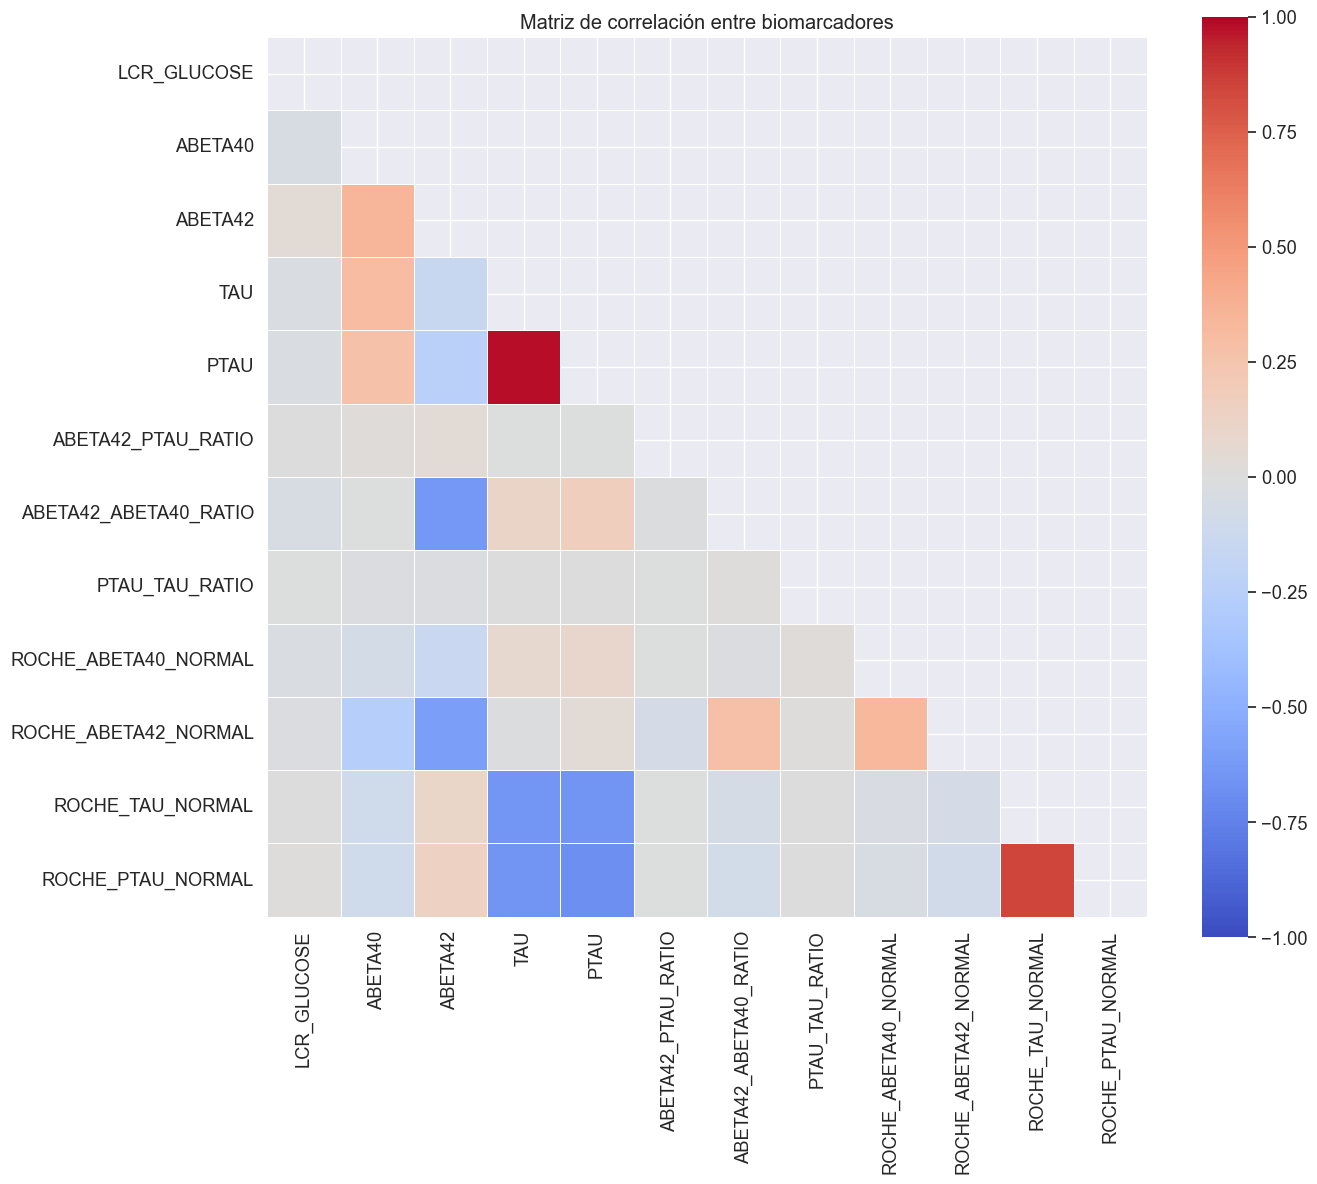

Correlaciones fuertes positívas entre biomarcadores:
TAU y PTAU: 0.981
ROCHE_TAU_NORMAL y ROCHE_PTAU_NORMAL: 0.847


In [50]:
def analyze_biomarker_correlations(df):
    """
    Analizar correlaciones entre biomarcadores
    """
    # Seleccionar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    # Calcular la matriz de correlación
    corr_matrix = df[numeric_cols].corr()
    
    # Visualizar la matriz de correlación
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, 
                vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Matriz de correlación entre biomarcadores')
    plt.tight_layout()
    plt.show()
    
    # Identificar correlaciones fuertes
    strong_correlations = []
    for i in range(len(numeric_cols)):
        for j in range(i+1, len(numeric_cols)):
            if abs(corr_matrix.iloc[i, j]) > 0.7:  # Umbral de correlación fuerte
                strong_correlations.append((numeric_cols[i], numeric_cols[j], corr_matrix.iloc[i, j]))
    
    print("Correlaciones fuertes positívas entre biomarcadores:")
    for var1, var2, corr in strong_correlations:
        print(f"{var1} y {var2}: {corr:.3f}")
    
    return strong_correlations

# Analizar correlaciones
strong_correlations = analyze_biomarker_correlations(integrated_biomarkers)

## Guardado de Datos Procesados

In [52]:
# Guardar los datasets procesados
processed_path = "../data/processed/"
interim_path = "../data/interim/"

# Crear el directorio si no existe
os.makedirs(processed_path, exist_ok=True)
os.makedirs(interim_path, exist_ok=True)

# Guardar cada dataset procesado en la carpeta Interim
biomark_processed.to_csv(os.path.join(interim_path, "biomark_processed.csv"), index=False)
lcrlab_processed.to_csv(os.path.join(interim_path, "lcrlab_processed.csv"), index=False)
roche_processed.to_csv(os.path.join(interim_path, "roche_processed.csv"), index=False)
urmc_processed.to_csv(os.path.join(interim_path, "urmc_processed.csv"), index=False)

# Guardar el dataset integrado en la carpeta Processed
integrated_biomarkers.to_csv(os.path.join(processed_path, "integrated_biomarkers.csv"), index=False)

print("Datasets induviduales (4) procesados guardados en:", interim_path)
print("Dataset unificado procesado guardados en:", processed_path)

Datasets induviduales (4) procesados guardados en: ../data/interim/
Dataset unificado procesado guardados en: ../data/processed/


## Resumen del Preprocesamiento

In [54]:
def summarize_preprocessing():
    """
    Función para generar un resumen del preprocesamiento realizado
    """
    print("Resumen del preprocesamiento de biomarcadores:")
    print("=" * 50)
    
    # Resumen de BIOMARK
    print("BIOMARK:")
    print(f"- Registros originales: {len(biomark_df)}")
    print(f"- Registros después del preprocesamiento: {len(biomark_processed)}")
    print(f"- Biomarcadores principales: Sin biomarcadores claves para el análisis.")
    print(f"- Nuevos biomarcadores calculados: Sin nuevos biomarcadores claves para el análisis.")
    
    # Resumen de LCRLAB
    print("\nLCRLAB:")
    print(f"- Registros originales: {len(lcrlab_df)}")
    print(f"- Registros después del preprocesamiento: {len(lcrlab_processed)}")
    biomarker_cols = [col for col in lcrlab_processed.columns if any(marker in col.upper() for marker in ['GLUC'])]
    print(f"- Biomarcadores procesados: {', '.join(biomarker_cols)}")
    
    # Resumen de ROCHE_ELECSYS
    print("\nROCHE ELECSYS:")
    print(f"- Registros originales: {len(roche_df)}")
    print(f"- Registros después del preprocesamiento: {len(roche_processed)}")
    print(f"- Biomarcadores normalizados con z-score")
    print(f"- Nuevas variables binarias para rangos normales y creación de ratios importantes.")
    
    # Resumen de URMC_LABDATA
    print("\nURMC LABDATA:")
    print(f"- Registros originales: {len(urmc_df)}")
    print(f"- Registros después del preprocesamiento: {len(urmc_processed)}")
    print(f"- Biomarcadores principales: Sin biomarcadores claves para el análisis.")
    print(f"- Nuevos biomarcadores calculados: Sin nuevos biomarcadores claves para el análisis.")
    if 'UnitsSI' in urmc_processed.columns:
        print(f"- Estandarización de unidades realizada")
    
    # Resumen del dataset integrado
    print("\nDATASET INTEGRADO:")
    print(f"- Total de registros: {len(integrated_biomarkers)}")
    print(f"- Total de características: {len(integrated_biomarkers.columns)}")
    print(f"- Identificadores únicos de pacientes: {integrated_biomarkers['RID'].nunique()}")
    print(f"- Valores faltantes después de imputación: {integrated_biomarkers.isnull().sum().sum()}")
    
    # Resumen de correlaciones
    if strong_correlations:
        print(f"\nTOTAL DE CORRELACIONES FUERTES IDENTIFICADAS: {len(strong_correlations)}")
    
    print("\nPRÓXIMOS PASOS:")
    print("- Integración con datos clínicos, de actividad y sueño, demográficos, genéticos y neuroimágenes.")
    print("- Feature selection para identificar los biomarcadores más relevantes")
    print("- Preparación para el modelado predictivo")

# Generar resumen
summarize_preprocessing()

Resumen del preprocesamiento de biomarcadores:
BIOMARK:
- Registros originales: 13416
- Registros después del preprocesamiento: 13416
- Biomarcadores principales: Sin biomarcadores claves para el análisis.
- Nuevos biomarcadores calculados: Sin nuevos biomarcadores claves para el análisis.

LCRLAB:
- Registros originales: 8072
- Registros después del preprocesamiento: 8072
- Biomarcadores procesados: GLUCOSE

ROCHE ELECSYS:
- Registros originales: 3174
- Registros después del preprocesamiento: 3174
- Biomarcadores normalizados con z-score
- Nuevas variables binarias para rangos normales y creación de ratios importantes.

URMC LABDATA:
- Registros originales: 113402
- Registros después del preprocesamiento: 113402
- Biomarcadores principales: Sin biomarcadores claves para el análisis.
- Nuevos biomarcadores calculados: Sin nuevos biomarcadores claves para el análisis.
- Estandarización de unidades realizada

DATASET INTEGRADO:
- Total de registros: 2450
- Total de características: 13
- 

## Conclusiones

En este cuaderno de preprocesamiento de biomarcadores, hemos:

1. Limpiado y estandarizado los cuatro conjuntos de datos de biomarcadores (BIOMARK, LCRLAB, ROCHE_ELECSYS y URMC_LABDATA)
2. Realizado tratamiento de valores atípicos e imputación de valores faltantes
3. Normalizado biomarcadores para hacerlos comparables
4. Calculado ratios importantes como PTAU/TAU que son críticos para el diagnóstico de Alzheimer
5. Integrado los diferentes conjuntos de datos (BIOMARK y URMC LABDATA fueron excluidos del integrado por no presentar biomarcadores relevantes para este análisis) en un único dataset consolidado
6. Analizado correlaciones entre los biomarcadores para identificar redundancias y relaciones importantes

Los datos procesados están listos para pasar a la siguiente fase de feature engineering y selección de características relevantes para el modelo predictivo de Alzheimer.

***



__Abraham Tartalos__